In [187]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import os
import warnings 
import glob
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay, recall_score
from PIL import Image
import os
from pylab import *
from utils import * 
from sklearn.model_selection import train_test_split
import json
import lzma
import json

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [115]:
files = []
likes = []
data = pd.DataFrame()
for i in glob.glob('data/*/*json.xz'):



    with lzma.open(i, "rt") as file:
        content = file.read()

    a = json.loads(content)
    like = a['node']['edge_media_preview_like']['count']
    files.append(i)
    likes.append(like)
data['files'] = files
data['likes'] = likes   


In [ ]:
for i in glob.glob('data/*'):
    source_directory = f'{i}/'  
    target_directory = f'{i}/images'  

    resize_images(source_directory, target_directory)

In [116]:
def get_path(path):
    parts = path.split("/")

    
    before_images = parts[0]+'/'+parts[1]
    return before_images

data['path'] = data['files'].apply(get_path)
data['path'].loc[0]

'data/kayaancontractor_100226_2868439159916464863_205_2'

In [120]:
Application_Credentials = '/Users/aladelca/Downloads/massive-acrobat-421018-1d8b6ce1a11a.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = Application_Credentials

In [117]:
name_keys = []
file_keys = []
df_file_name = pd.DataFrame()
for i in glob.glob('data/*/images/*'):
    parts = i.split("images")
    before_images = parts[0].strip("/")
    name_keys.append(before_images)
    for j in glob.glob(f'{i}*'):
        file_keys.append(j)
        

df_file_name['name_keys'] = name_keys
df_file_name['file_keys'] = file_keys
data_merged = pd.merge(data, df_file_name, left_on='path', right_on='name_keys', how='left')


In [17]:
def get_features_images_path():
    df = pd.DataFrame()

    for i in glob.glob('data/*/images/*.jpg'):
        a = detect_objects(i)
        a['path'] = i
        df = pd.concat([df, a])
   
    return df
features = get_features_images_path()
features.to_csv('features.csv')

In [119]:
features = pd.read_csv('features.csv')
b = features.pivot_table(
                            index=['path'],
                            columns='objects',
                            values='scores',
                            aggfunc='mean'
                        )
b.columns = [i.lower().replace(' ','_') for i in b.columns]
b = b.reset_index()
b = b.fillna(0)


Text(0.5, 1.0, 'Top 10 objects in images')

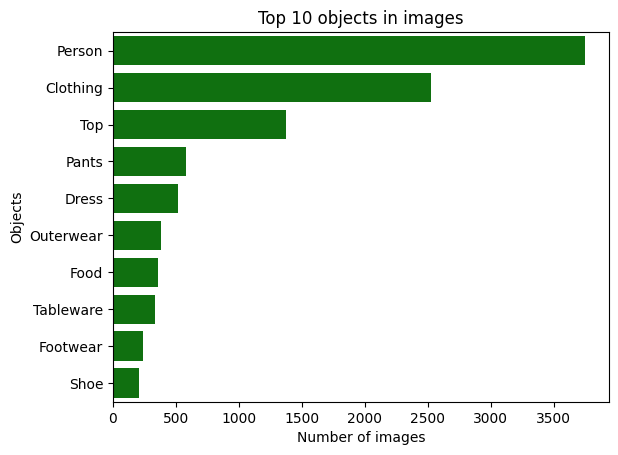

In [74]:
a = features.groupby(['objects']).agg({'path':'nunique'}).sort_values('path', ascending=False).head(10)
sns.barplot(y=a.index, x='path', data=a, color = 'green')
plt.xlabel('Number of images')
plt.ylabel('Objects')
plt.title('Top 10 objects in images')

Text(0.5, 1.0, 'Top 10 mean scores in images')

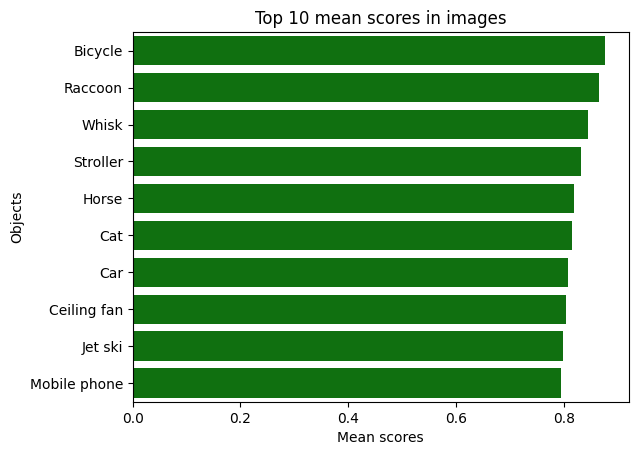

In [80]:
a = features.groupby(['objects']).agg({'scores':'mean'}).sort_values('scores', ascending=False).head(10)
sns.barplot(y=a.index, x='scores', data=a, color = 'green')
plt.xlabel('Mean scores')
plt.ylabel('Objects')
plt.title('Top 10 mean scores in images')

In [111]:
c = b.loc[:, b.columns != 'path'].corr()['clothing'].reset_index()
c['abs'] = c['clothing'].abs()
c = c.sort_values('abs', ascending=False).head(10)
c = c[c['index']!= 'clothing']
c

,index,clothing,abs
171,person,0.466920,0.466920
228,top,0.431968,0.431968
98,food,-0.275618,0.275618
214,tableware,-0.228403,0.228403
34,bowl,-0.169126,0.169126
165,pants,0.154225,0.154225
56,car,-0.132601,0.132601
195,shorts,0.127690,0.127690
176,plate,-0.125991,0.125991


Text(0.5, 1.0, 'Top 10 objects correlated with clothing')

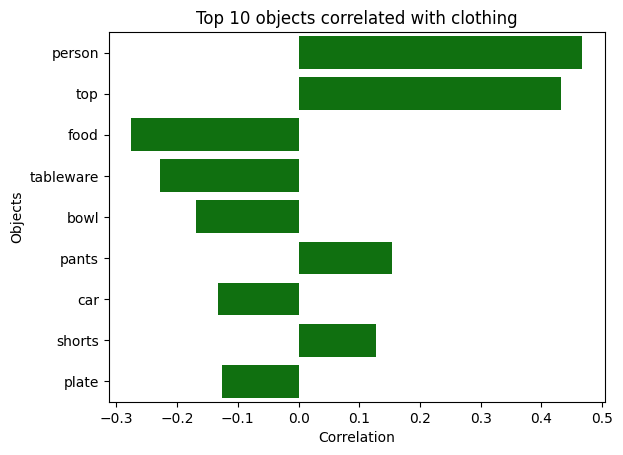

In [112]:
sns.barplot(y = c['index'], x = c['clothing'], color = 'green')
plt.xlabel('Correlation')
plt.ylabel('Objects')
plt.title('Top 10 objects correlated with clothing')

In [122]:
data_final = data_merged.merge(b, left_on = ['file_keys'], right_on = ['path'], how = 'left')
data_final['likes'] = data_final['likes'].replace(-1,0)
data_final['target'] = np.where(data_final['likes']>500000,1,0)
data_final = data_final.fillna(0)

In [121]:
images = load_and_prepare_images(data_final, 'file_keys')
target = data_final['target'].values.astype('float32')

In [267]:

#data = pd.DataFrame()
#df_features = pd.DataFrame()
#for influencer in influencers:
#    data = pd.concat([data, preprocessing(influencer)])
#    data = data.reset_index(drop=True)
#    df_features = pd.concat([df_features,get_features_images(influencer)])
#    df_features = df_features.reset_index(drop=True)


In [269]:
#df_final = preprocess_features(df_features, data)

In [123]:
#images = load_and_prepare_images(data)
#likes = df_final['likes'].values.astype('float32')

images.shape

(5516, 128, 128, 3)

In [124]:
x_train, x_test, y_train, y_test = train_test_split(images, target, test_size=0.2, random_state=123)
df_train, df_test = train_test_split(data_final, test_size=0.2, random_state=123)
x_fit, x_val, y_fit, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=123)
df_fit, df_val = train_test_split(df_train, test_size=0.2, random_state=123)
print(df_train.shape, df_test.shape, df_fit.shape, df_val.shape)


(4412, 262) (1104, 262) (3529, 262) (883, 262)


In [272]:
#enc = OneHotEncoder()
#df_fit_enc = pd.concat([pd.DataFrame(enc.fit_transform(df_fit[['influencer']]).toarray(), 
#                          columns = enc.categories_[0], 
#                          index = df_fit.index),
#                          df_fit.drop(columns = ['influencer'])], axis = 1)
#df_val_enc = pd.concat([pd.DataFrame(enc.transform(df_val[['influencer']]).toarray(),
#                          columns = enc.categories_[0],
#                          index = df_val.index),
#                          df_val.drop(columns = ['influencer'])], axis = 1)

#df_test_enc = pd.concat([pd.DataFrame(enc.transform(df_test[['influencer']]).toarray(),
#                           columns = enc.categories_[0],
#                           index = df_test.index),
#                           df_test.drop(columns = ['influencer'])], axis = 1)

In [178]:
#df_fit_enc = df_fit_enc.fillna(0)
#df_val_enc = df_val_enc.fillna(0)
#df_test_enc = df_test_enc.fillna(0) 


In [125]:
### Scaling
DROP_VARS = ['likes','fecha_utc','hashtags','comentarios','key_date','filename','caption','img_source','clean_path']
NOT_CONSIDERED_COLUMNS = ['files', 'likes', 'path_x', 'name_keys', 'file_keys', 'path_y','target']
esc = MinMaxScaler()
df_fit_esc = esc.fit_transform(df_fit.loc[:, ~df_fit.columns.isin(NOT_CONSIDERED_COLUMNS)])
df_val_esc = esc.transform(df_val.loc[:, ~df_val.columns.isin(NOT_CONSIDERED_COLUMNS)])
df_test_esc = esc.transform(df_test.loc[:, ~df_test.columns.isin(NOT_CONSIDERED_COLUMNS)])

df_fit_esc = np.nan_to_num(df_fit_esc, 0)
df_val_esc = np.nan_to_num(df_val_esc, 0)
df_test_esc = np.nan_to_num(df_test_esc, 0)

In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

K.clear_session()
image_input = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D(2, 2)(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.5)(x) 
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)


influencer_input = Input(shape=(df_fit_esc.shape[1],))
y = Dense(10, activation='relu')(influencer_input) 


combined = concatenate([x, y])


z = Dense(256, activation='relu')(combined)

z = Dense(1, activation = 'sigmoid')(z)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
model = Model(inputs=[image_input, influencer_input], outputs=z)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit([x_fit, df_fit_esc], y_fit, 
          epochs=10, 
          validation_data=([x_val, df_val_esc], y_val),
          callbacks=[early_stopping])

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.8957 - loss: 1.3822 - val_accuracy: 0.9037 - val_loss: 0.5106
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.9089 - loss: 0.2868 - val_accuracy: 0.9037 - val_loss: 0.4026
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9095 - loss: 0.2588 - val_accuracy: 0.9037 - val_loss: 0.3220
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.9093 - loss: 0.2392 - val_accuracy: 0.9015 - val_loss: 0.3177
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.9074 - loss: 0.2379 - val_accuracy: 0.9026 - val_loss: 0.3032
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.9269 - loss: 0.1826 - val_accuracy: 0.9026 - val_loss: 0.3241
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9416 - loss: 0.1520 - val_accuracy: 0.8867 - val_loss: 0.3544
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9531 - loss: 0.1205 - val_ac

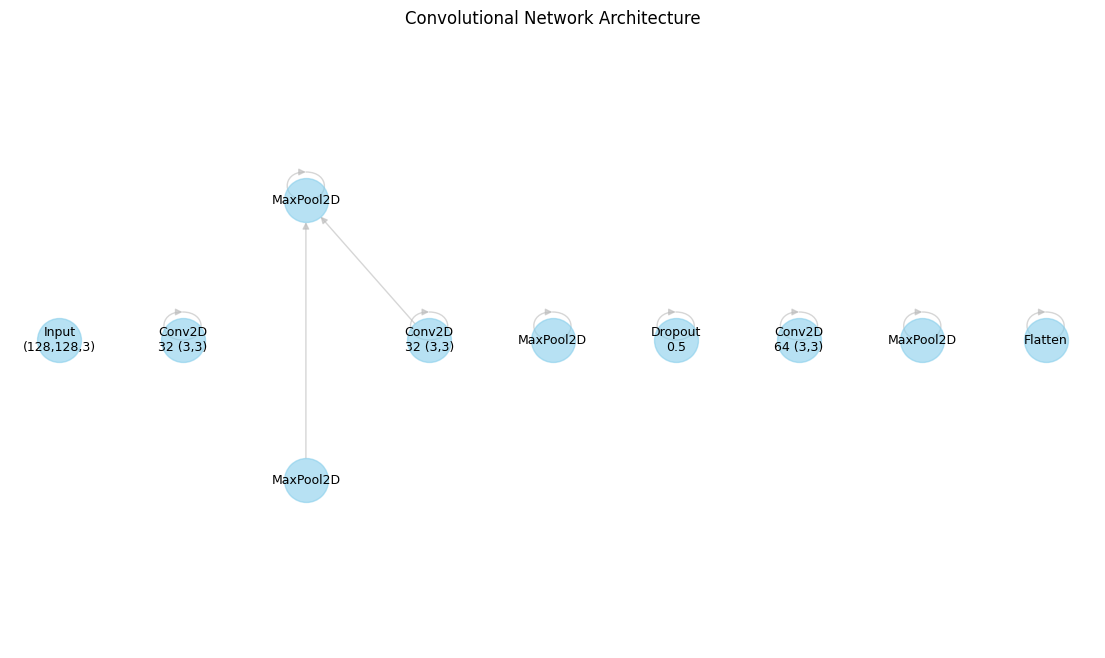

In [18]:
def draw_paper_neural_net(ax, layer_sizes, layer_texts):
    """
    Draw a neural network configured for inclusion in a research paper, with clean labels and proper connections.
    """
    n_layers = len(layer_sizes)
    v_spacing = (1 - 0) / float(max(layer_sizes))
    h_spacing = (1 - 0) / float(len(layer_sizes) - 1)
    node_radius = 0.05
    nodes = []
    edges = []
    layer_positions = []

    # Nodes
    for n, (layer_size, texts) in enumerate(zip(layer_sizes, layer_texts)):
        layer_top = v_spacing * (layer_size - 1) / 2. + 0.5
        positions = []
        for m in range(layer_size):
            node_x = n * h_spacing
            node_y = layer_top - m * v_spacing
            nodes.append((node_x, node_y))
            positions.append((node_x, node_y))
            if n > 0:
                for o in range(layer_sizes[n-1]):
                    edges.append((len(nodes) - 1, len(nodes) - 1 - m - o * layer_sizes[n-1]))
        layer_positions.append(positions)

    # Drawing
    ax.set_xlim(-node_radius, 1 + node_radius)
    ax.set_ylim(-node_radius, 1 + node_radius)
    ax.axis('off')
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    G.add_edges_from(edges)
    pos = dict(zip(range(len(nodes)), nodes))

    nx.draw(G, pos, with_labels=False, node_size=1000, ax=ax, node_color='skyblue', alpha=0.6, edge_color="#BBBBBB")
    
    # Adding text labels
    for layer, positions in zip(layer_texts, layer_positions):
        for position, text in zip(positions, layer):
            ax.text(position[0], position[1], text, ha='center', va='center', fontsize=9)

# Correcting layer connection
layer_sizes = [1, 1, 2, 1, 1, 1, 1, 1, 1]
layer_texts = [
    ["Input\n(128,128,3)"],  # Image input
    ["Conv2D\n32 (3,3)"],   # Conv2D 32 filters
    ["MaxPool2D", "MaxPool2D"],  # Double MaxPooling
    ["Conv2D\n32 (3,3)"],   # Second Conv2D 32 filters
    ["MaxPool2D"],          # MaxPooling
    ["Dropout\n0.5"],       # Dropout
    ["Conv2D\n64 (3,3)"],   # Third Conv2D 64 filters
    ["MaxPool2D"],          # MaxPooling
    ["Flatten"]             # Flatten
]

fig, ax = plt.subplots(figsize=(14, 8))
draw_paper_neural_net(ax, layer_sizes, layer_texts)
plt.title("Convolutional Network Architecture")
plt.show()

In [47]:
### Finding the best threshold (Youden Index)
predictions = model.predict([x_test, df_test_esc])
list_sensitivity = []
list_specificity = []
for i in np.arange(0.01, 1, 0.01):
    preds = np.where(predictions>i,1,0)
    list_sensitivity.append(recall_score(y_test, preds, pos_label=1))
    list_specificity.append(recall_score(y_test, preds, pos_label=0))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [123]:
best_threshold = np.arange(0.01, 1, 0.01)[np.argmax(np.array(list_sensitivity) + np.array(list_specificity) - 1)]
final_preds = np.where(predictions>best_threshold,1,0)


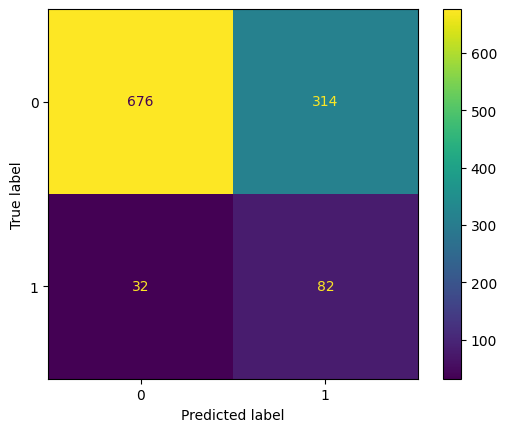

In [124]:
cm = confusion_matrix(y_test, final_preds)
ConfusionMatrixDisplay(cm).plot()

In [135]:

print(roc_auc_score(y_test, predictions))
print(accuracy_score(y_test, final_preds))
print(recall_score(y_test, final_preds, pos_label=1))
print(recall_score(y_test, final_preds, pos_label=0))


0.7194577352472089
0.6865942028985508
0.7192982456140351
0.6828282828282828


In [179]:
def predict(path):
    source = path
    target = path+'/images'
    resize_images(source, target)
    features = pd.DataFrame()
    data_images = pd.DataFrame()
    data_images['path'] = glob.glob('demo/images/*.jpg')

    for i in glob.glob(f'{path}/images/*.jpg'):
        print(i)
        a = detect_objects(i)
        print(a)
        a['path'] = i
        features = pd.concat([features, a])
    
    b = features.pivot_table(
                                index=['path'],
                                columns='objects',
                                values='scores',
                                aggfunc='mean'
                            )
    b.columns = [i.lower().replace(' ','_') for i in b.columns]
    b = b.reset_index()
    b = b.fillna(0)
    NOT_CONSIDERED_COLUMNS = ['files', 'likes', 'path_x', 'name_keys', 'file_keys', 'path_y','target','path']
    c = pd.DataFrame(columns=df_fit.loc[:, ~df_fit.columns.isin(NOT_CONSIDERED_COLUMNS)].columns)
    images = load_and_prepare_images(data_images, 'path')
    c[[i for i in b.columns if i not in NOT_CONSIDERED_COLUMNS]] = b[[i for i in b.columns if i not in NOT_CONSIDERED_COLUMNS]]
    c = c.fillna(0)
    c = esc.transform(c)
    return model.predict([images, c])

In [189]:
glob.glob('demo/images/*.jpg')
predict('demo')

demo/images/2023-10-17_17-47-48_UTC.jpg
    objects    scores                                     path
0    Person  0.856775  demo/images/2023-10-17_17-47-48_UTC.jpg
1    Shorts  0.827158  demo/images/2023-10-17_17-47-48_UTC.jpg
2  Clothing  0.787883  demo/images/2023-10-17_17-47-48_UTC.jpg
3       Top  0.782288  demo/images/2023-10-17_17-47-48_UTC.jpg
4       Top  0.759744  demo/images/2023-10-17_17-47-48_UTC.jpg
5  Clothing  0.743900  demo/images/2023-10-17_17-47-48_UTC.jpg
6     Pants  0.742360  demo/images/2023-10-17_17-47-48_UTC.jpg
7    Person  0.694127  demo/images/2023-10-17_17-47-48_UTC.jpg
8    Person  0.672172  demo/images/2023-10-17_17-47-48_UTC.jpg
9    Person  0.608928  demo/images/2023-10-17_17-47-48_UTC.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[0.13438329]], dtype=float32)